# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [134]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [138]:
# Data is loaded here
field_data = pd.read_csv("reduced_field_data.csv", index_col=0)
crit_data = pd.read_csv("flow_criticality_data.csv", index_col=0)

crit_data.head()

,flow_89_94,flow_20_23,flow_49_64,flow_101_532,flow_26_28,flow_172_176,flow_122_130,flow_105_116,flow_193_194,flow_187_191
Time,,,,,,,,,,
2012-01-01 00:00:00,0.296633,0.144482,0.341926,0.429794,0.107191,0.501129,0.954522,0.157365,0.555081,0.215995
2012-01-01 01:00:00,0.286880,0.140814,0.345723,0.435347,0.109399,0.484324,0.957007,0.168160,0.526282,0.161886
2012-01-01 02:00:00,0.221261,0.139097,0.329172,0.402732,0.258004,0.473216,0.964564,0.151398,0.512717,0.114494
2012-01-01 03:00:00,0.139193,0.159584,0.322661,0.380344,0.298660,0.416357,0.756591,0.061982,0.518129,0.078985
2012-01-01 04:00:00,0.090387,0.167504,0.288663,0.314070,0.287543,0.399404,0.724427,0.063575,0.515229,0.062350


## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


In [139]:
#Because the two dataframes is not the same length
crit_data2 = crit_data[crit_data.index.isin(field_data['time'])].dropna(axis=0)
print("Crit_data shape:",crit_data2.shape)
print("Crit_data2 shape:",crit_data.shape)
print("Field_data shape:",field_data.shape)

field_data = field_data.drop('time',1)

print("The shapes now fit")



Crit_data shape: (8311, 10)
Crit_data2 shape: (8784, 10)
Field_data shape: (8311, 21)
The shapes now fit


Overall error: 26091.7741


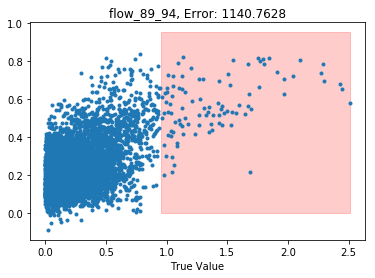

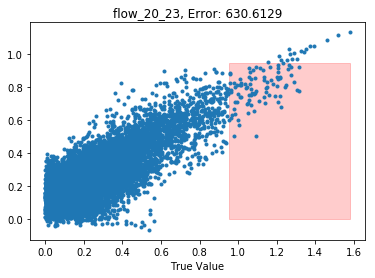

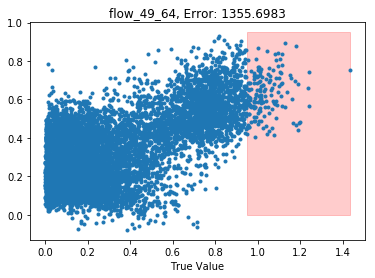

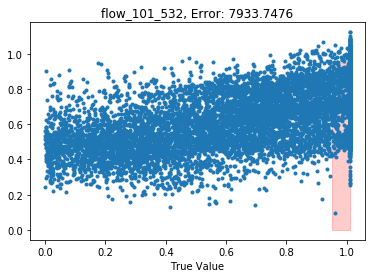

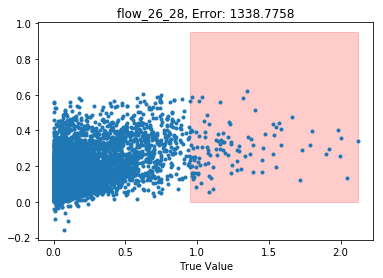

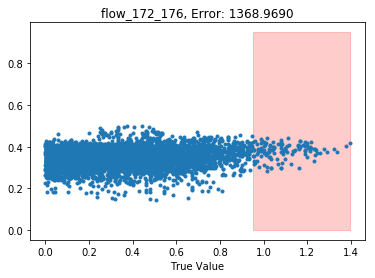

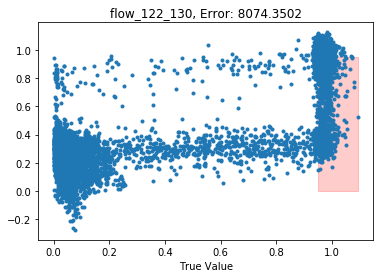

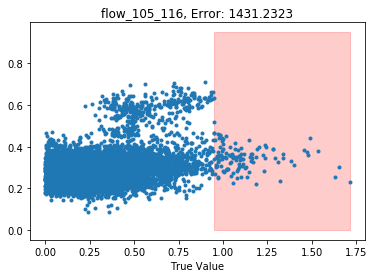

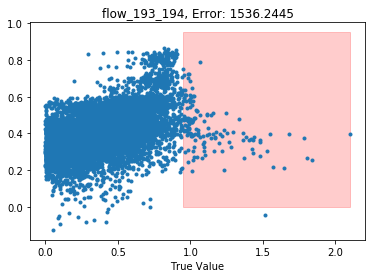

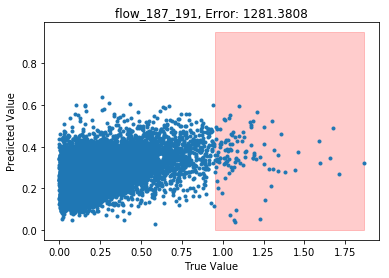

In [140]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(field_data,crit_data2)

y_pred = lm.predict(field_data)
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, crit_data2.iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(crit_data2.iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],crit_data2.iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(crit_data2.columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, crit_data2)))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?


No!   Linear regression is kinda the default regression. It should be used as a baseline to compare the real model to. In some ideal cases linear regression might be the best, but if you are working with real-world data it is uncommon.  

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?

You asked for a linear regression, so i only added 1 layer with the activation type 'linear'. I chose Dense(10) because it didn't work otherwise.  

I got a mean_squarred_error of 2.4839886749859565 with that 1 layer.


In [48]:
# Split data into training and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(field_data,
                                                    crit_data2, 
                                                    test_size=0.25, 
                                                    random_state=42)


In [132]:
#INSERT Neural Network Code here for a linear regression.

# Remember to import the kind of layers you want from the keras library.
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors1 = list()

for i in range(0,30):
    model = Sequential()
    model.add(Dense(10, input_shape=(27,)))
    model.add(Activation('linear'))

    adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=score_func, optimizer=adam)
    history1=model.fit(x_train.values,y_train.values, epochs = 100, batch_size=500, shuffle=False)
    y_pred2 = model.predict(x_test.values, batch_size = 1000)
    listOfErrors1.append(history1.history['loss'][-1])
    
plt.hist(listOfErrors1)
plt.grid(True)
plt.show()


AttributeError: 'Tensor' object has no attribute 'sum'

In [124]:
min(listOfErrors1)

2.4839886749859565

# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.H

KFold(n_splits=10, random_state=None, shuffle=True)
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 721165.5714      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 152632.6691     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 41796.9128     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 13831.9957     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 5693.7789     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 2965.8726     
Epoch 7/100
6257/6257 [==============================] - 0s - loss: 1974.9889     
Epoch 8/100
6257/6257 [==============================] - 0s - loss: 1534.9195     
Epoch 9/100
6257/6257 [==============================] - 0s - loss: 1283.7343     
Epoch 10/100
6257/6257 [==============================] - 0s - loss: 1126.9601     
Epoch 11/100
6257/6257 [==============================] - 0s - loss: 1001.6203     
Epoch 12/100
6257/6257 [==

6257/6257 [==============================] - 0s - loss: 1530.7827     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 467.5544     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 932152.5946      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 192871.3247     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 55032.8122     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 17397.0287     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 5810.5866     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 2393.2101     
Epoch 7/100
6257/6257 [==============================] - 0s - loss: 1308.2739     
Epoch 8/100
6257/6257 [==============================] - 0s - loss: 884.7120     
Epoch 9/100
6257/6257 [==============================] - 0s - loss: 682.3458     
Epoch 10/100
6257/6257 [==============================] - 0s - loss: 567.0525     
Epoch 11/1

6257/6257 [==============================] - 0s - loss: 28.0799     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 23.0011      ETA: 0s - loss: 21.80
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 19.0886     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 642286.0368      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 131086.5256     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 39938.0980     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 12724.8701     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 4769.2349     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 2370.1358     
Epoch 7/100
6257/6257 [==============================] - 0s - loss: 1442.0407     
Epoch 8/100
6257/6257 [==============================] - 0s - loss: 1050.0757     
Epoch 9/100
6257/6257 [==============================] - 0s - loss: 858.0

6257/6257 [==============================] - 0s - loss: 286.8798     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 152.3148     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 74.9947     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 54.8447     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 803198.2043      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 167342.1764     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 47801.1342     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 14993.0387     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 5688.0601     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 2602.5666     
Epoch 7/100
6257/6257 [==============================] - 0s - loss: 1564.3159     
Epoch 8/100
6257/6257 [==============================] - 0s - loss: 1130.9252     
Epoch 9/100

6257/6257 [==============================] - 0s - loss: 39.3727     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 95.4097     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 2742.3583     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 611.5167     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 82.4362      
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 709505.4268      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 159997.5720     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 44884.2782     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 15081.5555     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 5674.8347     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 2656.0785     
Epoch 7/100
6257/6257 [==============================] - 0s - loss: 1650.0513     
Epoch 8/10

6257/6257 [==============================] - 0s - loss: 465.2546     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 197.0212     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 84.7853     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 55.4347     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 307.2457     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 2212.5397     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 607388.7815       
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 135468.0850     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 36195.1624     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 11058.2668     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 4207.3277     
Epoch 6/100
6257/6257 [==============================] - 0s - loss: 1947.9280     
Epoch 7/1

6257/6257 [==============================] - 0s - loss: 14.3737     
Epoch 95/100
6257/6257 [==============================] - 0s - loss: 13.5901     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 29.3271     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 3159.0137     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 1154.0675     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 626.3695     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 4636.6845     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 646183.1190      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 133290.1831     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 36611.5552     
Epoch 4/100
6257/6257 [==============================] - 0s - loss: 12103.5524     
Epoch 5/100
6257/6257 [==============================] - 0s - loss: 4581.8887     
Epoch 6/1

6257/6257 [==============================] - 0s - loss: 10.5667     
Epoch 93/100
6257/6257 [==============================] - 0s - loss: 10.7202     
Epoch 94/100
6257/6257 [==============================] - 0s - loss: 442.5482     
Epoch 95/100
6257/6257 [==============================] - 0s - loss: 5156.8385     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 1262.1380     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 274.0102     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 96.7418     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 317.9053     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 2130.5038     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 633608.4047      
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 145665.2173     
Epoch 3/100
6257/6257 [==============================] - 0s - loss: 39641.6497     
Epoch 4/10

6257/6257 [==============================] - 0s - loss: 46.8540     
Epoch 92/100
6257/6257 [==============================] - 0s - loss: 2138.9354     
Epoch 93/100
6257/6257 [==============================] - 0s - loss: 1396.9854    
Epoch 94/100
6257/6257 [==============================] - 0s - loss: 5160.4056     
Epoch 95/100
6257/6257 [==============================] - 0s - loss: 2283.2122     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 450.6520     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 67.7435     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 56.5992     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 43.1815     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 26.8563     
Epoch 1/100
6257/6257 [==============================] - 1s - loss: 655625.7293       
Epoch 2/100
6257/6257 [==============================] - 0s - loss: 145440.0126     
Epoch 3/100


6257/6257 [==============================] - 0s - loss: 10.9984     
Epoch 91/100
6257/6257 [==============================] - 0s - loss: 10.9444     
Epoch 92/100
6257/6257 [==============================] - 0s - loss: 12.7833     
Epoch 93/100
6257/6257 [==============================] - 0s - loss: 20.5626     
Epoch 94/100
6257/6257 [==============================] - 0s - loss: 1303.0199    
Epoch 95/100
6257/6257 [==============================] - 0s - loss: 1288.0553     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 353.9970     
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 3245.6415     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 790.9592     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 188.7832     
Epoch 100/100
6257/6257 [==============================] - 0s - loss: 39.8423     
Epoch 1/100
6257/6257 [==============================] - 0s - loss: 755117.3164      
Epoch 2/100
6257

6257/6257 [==============================] - 0s - loss: 26.2820     
Epoch 89/100
6257/6257 [==============================] - 0s - loss: 25.9269     
Epoch 90/100
6257/6257 [==============================] - 0s - loss: 26.0270     
Epoch 91/100
6257/6257 [==============================] - 0s - loss: 29.4678     
Epoch 92/100
6257/6257 [==============================] - 0s - loss: 25.6053     
Epoch 93/100
6257/6257 [==============================] - 0s - loss: 521.6784    
Epoch 94/100
6257/6257 [==============================] - 0s - loss: 4398.1735     
Epoch 95/100
6257/6257 [==============================] - 0s - loss: 1043.5623     
Epoch 96/100
6257/6257 [==============================] - 0s - loss: 1930.9503    
Epoch 97/100
6257/6257 [==============================] - 0s - loss: 1626.5246     
Epoch 98/100
6257/6257 [==============================] - 0s - loss: 307.1002     
Epoch 99/100
6257/6257 [==============================] - 0s - loss: 79.9782     
Epoch 100/100
6257/62

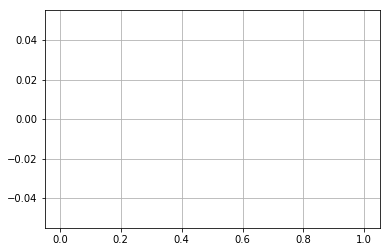

AttributeError: 'list' object has no attribute 'mean'

In [125]:
# Your k-fold code goes here.
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()


kf1 = KFold(n_splits=10,shuffle=True)
print(kf1)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data2.iloc[train_index], crit_data2.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(27,)))
    model.add(Activation('linear'))

    adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1=model.fit(x_train.values,y_train.values, epochs = 100, batch_size=500, shuffle=False)
    y_pred2 = model.predict(x_test.values, batch_size = 1000)
    listOfErrors1.append(history1.history['loss'][-1])
    
plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("mean score: ",listOfErrors2.mean)

**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?